In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import scipy.stats
from scipy.stats.mstats import gmean
import scipy.stats as stats
import math
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams["font.sans-serif"] = "Arial"



# 1.Normalization

In [5]:
countF = 'CRPstim_Refseq_rawcounts.txt'
countDF = pd.read_table(countF,sep='\t',index_col=0)
countDF = countDF.groupby('GeneSymbol').mean().astype(int)         #average transcripts
print ('Raw data:')
print (countDF.head(3))
print (' ')
countDF.to_csv('CRPstim.gene.txt',sep='\t')
def Log2(L):return np.array([math.log(i+1.0,2) for i in L])
def DEseqNorm(DF):
    factor=(DF.T/DF.apply(gmean,axis=1)).dropna(axis=1,how='any').apply(np.median,axis=1)
    DF=DF/factor
    DFlog=DF.apply(Log2)
    factor.to_csv('Deseq.sizefactor.txt',sep='\t')
    DF.to_csv('RNAseq_DEseq.txt',sep='\t')
    DFlog.to_csv('RNAseq_DEseq.log2.txt',sep='\t')
    print ('DEseq Normalied data:')
    print (DF.head(3))
    print (' ')
    print ('DEseq Normalied Log2 data:')
    print (DFlog.head(3))
DEseqNorm(countDF)

print (' ')
print ('Normalization Done!')

Raw data:
            OAM091ctrl  OAM093ctrl  OAM094ctrl  OAM091stim  OAM093stim  \
GeneSymbol                                                               
A1BG                15           4           2           0           3   
A1BG-AS1            14           0           9         136           0   
A1CF                 0           0           9           0           0   

            OAM094stim  
GeneSymbol              
A1BG                 3  
A1BG-AS1             0  
A1CF                 0  
 


/Users/huangbeibei/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:330: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))


DEseq Normalied data:
            OAM091ctrl  OAM093ctrl  OAM094ctrl  OAM091stim  OAM093stim  \
GeneSymbol                                                               
A1BG         24.859898    6.858572    1.894979    0.000000    1.478786   
A1BG-AS1     23.202572    0.000000    8.527405  132.809592    0.000000   
A1CF          0.000000    0.000000    8.527405    0.000000    0.000000   

            OAM094stim  
GeneSymbol              
A1BG           2.52011  
A1BG-AS1       0.00000  
A1CF           0.00000  
 
DEseq Normalied Log2 data:
            OAM091ctrl  OAM093ctrl  OAM094ctrl  OAM091stim  OAM093stim  \
GeneSymbol                                                               
A1BG          4.692645    2.974267    1.533553    0.000000    1.309634   
A1BG-AS1      4.597088    0.000000    3.252083    7.064038    0.000000   
A1CF          0.000000    0.000000    3.252083    0.000000    0.000000   

            OAM094stim  
GeneSymbol              
A1BG           1.81562  
A1BG-AS

# 2.Data Feature

In [18]:
outDir=os.path.join('DataFeature')
if not os.path.exists(outDir):
    os.mkdir(outDir)

F='RNAseq_DEseq.log2.txt'
RNA=pd.read_table(F,sep='\t',index_col=0)

ColorF='SamplesColor.txt'   #set samples color and label
ColorDF=pd.read_table(ColorF,sep='\t',index_col=0)
LabelF='SamplesLabel.txt'
LabelDF=pd.read_table(LabelF,sep='\t',index_col=0)


Normalized data distribution:


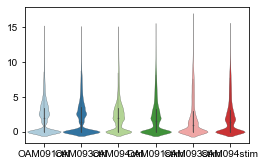

Heatmap of samples pearson correlation:


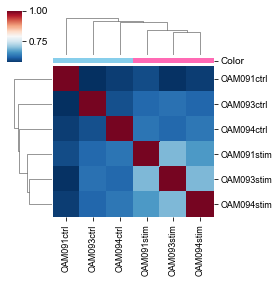

Sactterplot of samples reproducible:


/Users/huangbeibei/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 360x360 with 0 Axes>

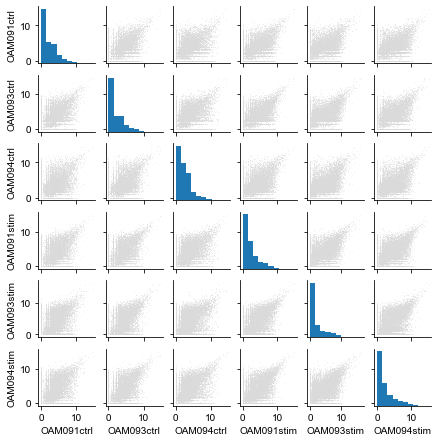

In [19]:
#Figure: normalized data distribution
print ('Normalized data distribution:')
fig=plt.figure(figsize=(4,2.5))
sns_plot = sns.violinplot(data=RNA,linewidth=0.25,palette = 'Paired', width=1)
outfig=outDir+'/DEseqNormLog2_DataDistribution'+'.pdf'
plt.savefig(outfig)
plt.show()

#Figure: Samples correlation
print ('Heatmap of samples pearson correlation:')
RNAT=np.array(RNA).T
RNAcorrcoef=np.corrcoef(RNAT)   #np.corrcoef: Pearson product-moment correlation coefficients
RNAcorrcoefDF=pd.DataFrame(RNAcorrcoef,index=list(RNA),columns=list(RNA))
fig=sns.clustermap(RNAcorrcoefDF,method='average',metric='correlation',cmap='RdBu_r',figsize=(4,4),col_colors=ColorDF,row_cluster=True,col_cluster=True,center=np.mean([RNAcorrcoefDF.min(),RNAcorrcoefDF.max()]),xticklabels=list(RNA),yticklabels=list(RNA),linecolor=None)
plt.setp(fig.ax_heatmap.get_yticklabels(), rotation=0, fontsize=9)
plt.setp(fig.ax_heatmap.get_xticklabels(), rotation=90, fontsize=9)
plt.savefig(outDir+'/DEseqNormLog2_SamplesCorr.pdf')
plt.show()

#Figure: Samples reproducible
print ('Sactterplot of samples reproducible:')
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(5,5))
sns.pairplot(RNA,size=1,markers='.',plot_kws = dict(s = 1, color='#dadada',edgecolor = None, linewidth = 0))
plt.savefig(outDir+'/DEseqNormLog2_SamplesRep.png',dpi=500)
plt.show()




# 3.DEgene analysis

In [21]:
#DE gene filter
#sum_of_count>5 & 
def DiseaseSpecific_pval(Dir,DF,pvalue,logFC,FC):
    RAs=[i for i in list(DF) if 'stim' in i]
    OAs=[i for i in list(DF) if 'ctrl' in i]
    DFsum=DF.apply(sum,axis=1)>5
    DFfilter=DF[DFsum]
    print ('Filter GeneNmuber : ',len(DFfilter))
    #DFfilter=DFfilter.drop('J01415.4')
    CountRA=DFfilter[RAs]
    CountOA=DFfilter[OAs]
    
    #cluster1(RA_vs_OA up)
    RAup_FD=(CountRA.apply(np.mean,axis=1)-CountOA.apply(np.mean,axis=1))>logFC
    RAup_Pval=(pd.Series(scipy.stats.ttest_ind(CountRA,CountOA,axis=1)[1],index=DFfilter.index)) < pvalue
    FilterDF_RAup=DFfilter[RAup_FD & RAup_Pval]
    #cluster2(OA_vs_RA up)
    RAdown_FD=(CountRA.apply(np.mean,axis=1)-CountOA.apply(np.mean,axis=1))<-logFC
    RAdown_Pval=(pd.Series(scipy.stats.ttest_ind(CountOA,CountRA,axis=1)[1],index=DFfilter.index)) < pvalue
    FilterDF_RAdown=DFfilter[RAdown_FD & RAdown_Pval]
    
    FilterDFall = DFfilter[(RAup_FD & RAup_Pval) | (RAdown_FD & RAdown_Pval)]
    print ('StimvsCon_fc{}_pvalue{}_Number: '.format(FC,pvalue))
    print ('    Stimup: ',len(FilterDF_RAup))
    print ('    Conup: ',len(FilterDF_RAdown))
    print ('    DEgene: ',len(FilterDFall))

    #write bed/count into file 
    with open(Dir+'/StimvsConup_genelist_{}.txt'.format(len(FilterDF_RAup)),'w') as f:
        for i in list(FilterDF_RAup.index):
            f.write('%s\n'%i)
    with open(Dir+'/StimvsCondown_genelist_{}.txt'.format(len(FilterDF_RAdown)),'w') as f:
        for i in list(FilterDF_RAdown.index):
            f.write('%s\n'%i)
            
    FilterDFall.to_csv(Dir+'/StimvsCon_DEgene_{}.txt'.format(len(FilterDFall)),sep='\t')
    #Heatmap:
    FilterDFall_Z = FilterDFall.apply(scipy.stats.zscore,axis=1,result_type='broadcast') #zscore
    fig=sns.clustermap(FilterDFall_Z,figsize=(3,4),center=0,vmin=-2,vmax=2,col_cluster=True,row_cluster=True,cmap='RdBu_r')                    
    fig.savefig(Dir + '/StimvsCon_DEgene_heatmap.pdf')
    plt.show()  

    

Filter GeneNmuber :  16776
StimvsCon_fc2_pvalue0.05_Number: 
    Stimup:  506
    Conup:  869
    DEgene:  1375


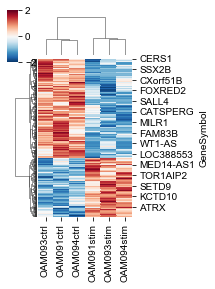

Filter GeneNmuber :  16776
StimvsCon_fc1_pvalue0.05_Number: 
    Stimup:  513
    Conup:  880
    DEgene:  1393


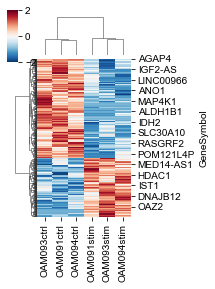

In [23]:
F='RNAseq_DEseq.log2.txt'
RNA=pd.read_table(F,sep='\t',index_col=0)


#sumcount5_pvalue0.05_log2fc1_fc2
Dir=os.path.join('DEgene_p0.05_fc2')
if not os.path.exists(Dir):
    os.mkdir(Dir)
DiseaseSpecific_pval(Dir,RNA,0.05,1,2)

#sumcount5_pvalue0.05_log2fc0.58_fc2
Dir=os.path.join('DEgene_p0.05_fc1.5')
if not os.path.exists(Dir):
    os.mkdir(Dir)
DiseaseSpecific_pval(Dir,RNA,0.05,0.585,1)